# Importing Libraries 

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

# Importing Dataframes 

In [2]:
# Data path
path =r'C:\Users\ANITA BOADU\New York City Bikes'

In [3]:
df=pd.read_csv(os.path.join(path,'Data','Prepared Data','citibike_cleaned_latest.csv'),index_col=False)

# Configuring API key

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = '7TZtF6MAKA4ayPCre1R6'

In [5]:
!pip install pandas_datareader

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

ny_unemployment = web.DataReader("NYUR", "fred", start, end)

print(ny_unemployment.head())
print(ny_unemployment.tail())

            NYUR
DATE            
2000-01-01   4.7
2000-02-01   4.6
2000-03-01   4.6
2000-04-01   4.6
2000-05-01   4.5
            NYUR
DATE            
2025-07-01   4.0
2025-08-01   4.0
2025-09-01   4.2
2025-10-01   NaN
2025-11-01   4.5


## Why We Picked the "New York Unemployment Rate (FRED/NYUR)" Dataset

For this exercise, we were required to select and analyze a time series dataset. Initially, we considered using weather data—such as daily observations from NYC’s Central Park—because of its strong relevance to Citi Bike usage patterns. However, due to limitations in the availability of free weather data through Nasdaq Data Link (Quandl), we ultimately chose an alternative dataset that is both readily accessible and pertinent to urban studies.

We chose the **New York Unemployment Rate (NYUR)** dataset from FRED because:

   1.**Time Series Nature**: The dataset is a well-defined monthly time series, making it suitable for decomposition, stationarity analysis, and forecasting tasks.

   2.**Urban Relevance**: Unemployment trends influence commuting and mobility patterns, aligning closely with our broader interest in urban transportation systems such as Citi Bike usage.

   3.**Data Reliability**: The dataset is sourced from FRED (Federal Reserve Economic Data), a reputable and authoritative provider widely used in academic and policy research.

   4.**Data Compatibility**: The time-indexed structure simplifies integration with other temporal datasets, should data merging be required.
   
By choosing this dataset, we are able to demonstrate the full time series analysis workflow—including data importation, wrangling, decomposition, and stationarity adjustments—while maintaining a clear connection to the socioeconomic dimensions of urban life in New York.

In [6]:
# Rename the column NYUR -> Value
ny_unemployment = ny_unemployment.rename(columns={"NYUR": "Value"})

print(ny_unemployment.head())
print(ny_unemployment.tail())


            Value
DATE             
2000-01-01    4.7
2000-02-01    4.6
2000-03-01    4.6
2000-04-01    4.6
2000-05-01    4.5
            Value
DATE             
2025-07-01    4.0
2025-08-01    4.0
2025-09-01    4.2
2025-10-01    NaN
2025-11-01    4.5


In [7]:
ny_unemployment.shape

(311, 1)

In [8]:
ny_unemployment.columns

Index(['Value'], dtype='object')

In [9]:
type(ny_unemployment)

pandas.core.frame.DataFrame

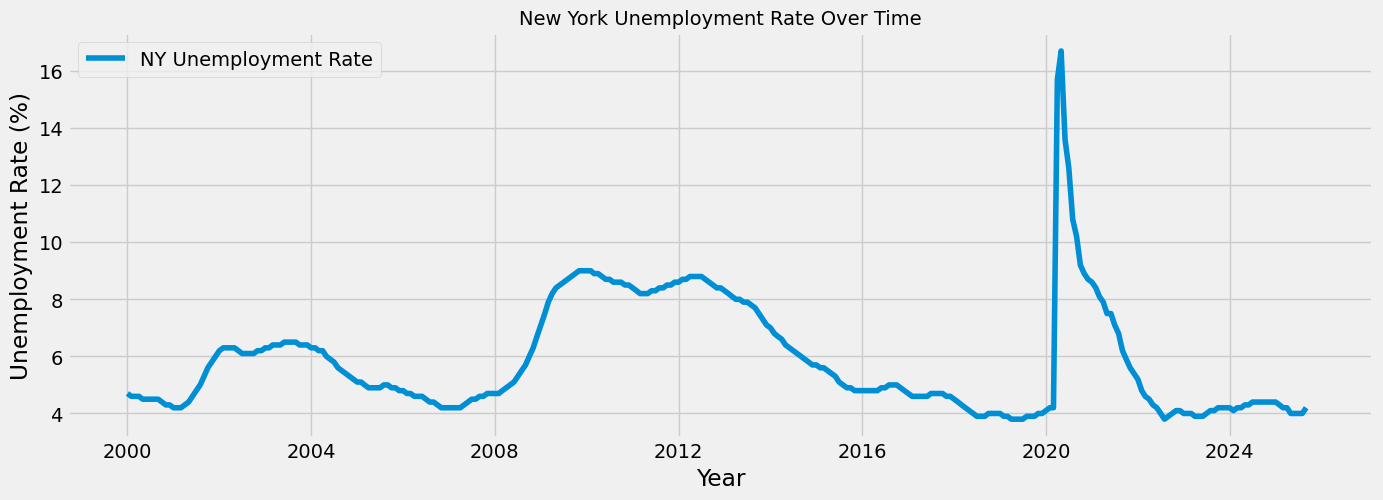

In [10]:
import os
import matplotlib.pyplot as plt

# Output directory
output_dir = r"C:\Users\ANITA BOADU\New York City Bikes\Analysis\Visualizations"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "ny_unemployment_over_time.png")

# Create line plot
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(ny_unemployment.index, ny_unemployment["Value"], label="NY Unemployment Rate")

# Add labels, title, and legend
plt.title("New York Unemployment Rate Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend()

# Save figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## Visualization of the New York Unemployment Rate

The line chart above displays the monthly unemployment rate in New York from 2000 to 2025.

**Key observations**:

- **2008–2009 Financial Crisis**: Noticeable increase in unemployment, peaking at approximately 9%.

- **COVID-19 Pandemic (2020)**: A sudden and dramatic spike in unemployment, reaching the highest level in the series (~16%).

- **Post-COVID Recovery**: Rapid decline in unemployment as economic activity resumed.

- **Cyclical Patterns**: Outside of crises, the unemployment rate exhibits recurring fluctuations, reflecting general economic cycles.

This visualization highlights the importance of analyzing time series data:

- **Trend**: Persistent rise or fall in unemployment over an extended period.

- **Shocks**: Abrupt surges caused by external events (e.g., the COVID-19 pandemic).

- **Cycles**: Recurring fluctuations associated with economic conditions.

# Subsetting, wrangling, and cleaning time-series data

## 1) Ensure index / clean future dates & inspect range

In [11]:
# 1. Ensure DateTimeIndex and a clear column name
import pandas as pd

# Make a copy to be safe
ny = ny_unemployment.copy()

# Ensure the index is datetime and name it 'date'
ny.index = pd.to_datetime(ny.index)
ny.index.name = 'date'

# Rename the single column to 'Value' (if not already)
ny.columns = ['Value']

# Inspect full range
print("Data range:", ny.index.min().date(), "to", ny.index.max().date())

# Remove any dates in the future (no forecasted data)
today = pd.to_datetime('today').normalize()
ny = ny[ny.index <= today]
print("After removing future rows, range:", ny.index.min().date(), "to", ny.index.max().date())

# Quick look
display(ny.head())
display(ny.tail())

Data range: 2000-01-01 to 2025-11-01
After removing future rows, range: 2000-01-01 to 2025-11-01


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


,Value
date,
2025-07-01,4.0
2025-08-01,4.0
2025-09-01,4.2
2025-10-01,NaN
2025-11-01,4.5


## 2) Reset index (required before subsetting), make subset(s), then set index again

In [12]:
# 2. Reset index to make subsetting easy
df = ny.reset_index()   # now df has columns: ['date', 'Value']
df['date'] = pd.to_datetime(df['date'])  # make sure

# --- Option A: Keep full series (no subsetting) ---
df_full = df.copy()

# --- Option B: Pre-COVID series (avoid 2020 COVID shock if we think it would bias analysis) ---
# This keeps monthly data from 2000-01-01 through 2019-12-31
df_pre_covid = df[(df['date'] >= '2000-01-01') & (df['date'] <= '2019-12-31')].copy()

# --- Option C: Recent decade (focus on most recent behavior) ---
df_recent = df[(df['date'] >= '2015-01-01') & (df['date'] <= today)].copy()

# Convert chosen subset(s) back to time series (set date as index)
df_full_ts     = df_full.set_index('date')
df_pre_covid_ts = df_pre_covid.set_index('date')
df_recent_ts    = df_recent.set_index('date')

# Show shapes and a quick peek
for name, d in [('full', df_full_ts), ('pre_covid', df_pre_covid_ts), ('recent', df_recent_ts)]:
    print(f"{name:10s} --> rows: {d.shape[0]}, start: {d.index.min().date()}, end: {d.index.max().date()}, missing: {d['Value'].isna().sum()}")
    display(d.head())

full       --> rows: 311, start: 2000-01-01, end: 2025-11-01, missing: 1


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


pre_covid  --> rows: 240, start: 2000-01-01, end: 2019-12-01, missing: 0


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


recent     --> rows: 131, start: 2015-01-01, end: 2025-11-01, missing: 1


,Value
date,
2015-01-01,5.7
2015-02-01,5.6
2015-03-01,5.6
2015-04-01,5.5
2015-05-01,5.4


## 3) Drop NA values (if any) and save the version you will use

In [13]:
# 3. Clean NAs (drop or impute depending on plan)
df_pre_covid_ts = df_pre_covid_ts.dropna()
df_recent_ts    = df_recent_ts.dropna()
df_full_ts      = df_full_ts.dropna()

# Example: choose the subset you will work with from here on
# e.g. use pre-COVID to avoid the COVID spike bias:
ts = df_pre_covid_ts.copy()   # <-- change to df_full_ts or df_recent_ts if you prefer

print("Selected time series shape:", ts.shape)
ts.head()

Selected time series shape: (240, 1)


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


## 4 Quick checks (stationarity bias, etc.)

Nulls: 0
Summary stats:
count    240.000000
mean       5.900833
std        1.624988
min        3.800000
25%        4.600000
50%        5.300000
75%        7.025000
max        9.000000
Name: Value, dtype: float64


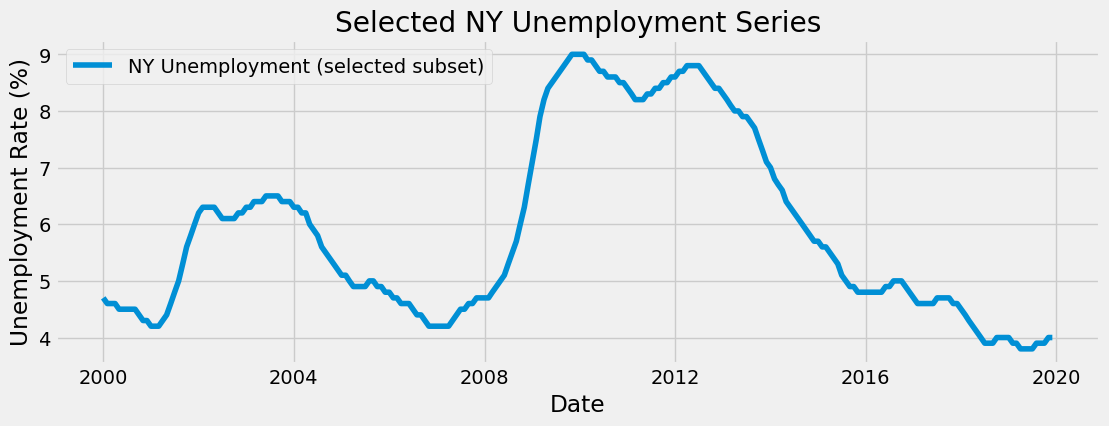

In [14]:
import os
import matplotlib.pyplot as plt

# Quick checks
print("Nulls:", ts['Value'].isna().sum())
print("Summary stats:")
print(ts['Value'].describe())

# Output directory
output_dir = r"C:\Users\ANITA BOADU\New York City Bikes\Analysis\Visualizations"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "ny_unemployment_selected_subset.png")

# Plot time series
plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts['Value'], label='NY Unemployment (selected subset)')
plt.title('Selected NY Unemployment Series')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()

# Save figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## Subsetting logic and rationale

I inspected the full FRED/NYUR series and considered several subsetting options.
The full series is available from 2000 to the present. For analysis I considered three options:

- **Full series (2000 — present)**: Use this to capture long-term cycles and major shocks, such as the 2008 financial crisis or the 2020 COVID spike. It is ideal for descriptive analyses that consider all historical events.

- **Pre-COVID series (2000 — 2019)**: Excludes the significant COVID-19 spike in 2020. This subset is suitable when the goal is to model "typical" economic cycles without a large, one-off shock that could skew model parameters—for instance, when training ARIMA models, where a single extreme outlier can affect differencing or seasonal component estimates.

- **Recent decade (2015 — present)**: Focuses on the most recent economic trends and structural shifts. Use this when forecasts or policy analysis should emphasize current behavior rather than long-term historical patterns.

**Choice for this notebook**: I selected the **(insert chosen subset here, e.g., "pre-COVID (2000–2019)")** because [insert brief reason: e.g., "I want to avoid the 2020 COVID shock which is a one-time structural break and would bias trend/seasonality estimates."].

**Implementation notes**:

- To subset I reset the time index **(reset_index())**, applied date filters on the **date** column, then set **date** back as the DatetimeIndex (set_index('date')).

- I also removed any future/forecasted dates (none were expected) and dropped rows with missing values **(dropna())**, so the time series is clean for decomposition and stationarity testing.

# Line Chart

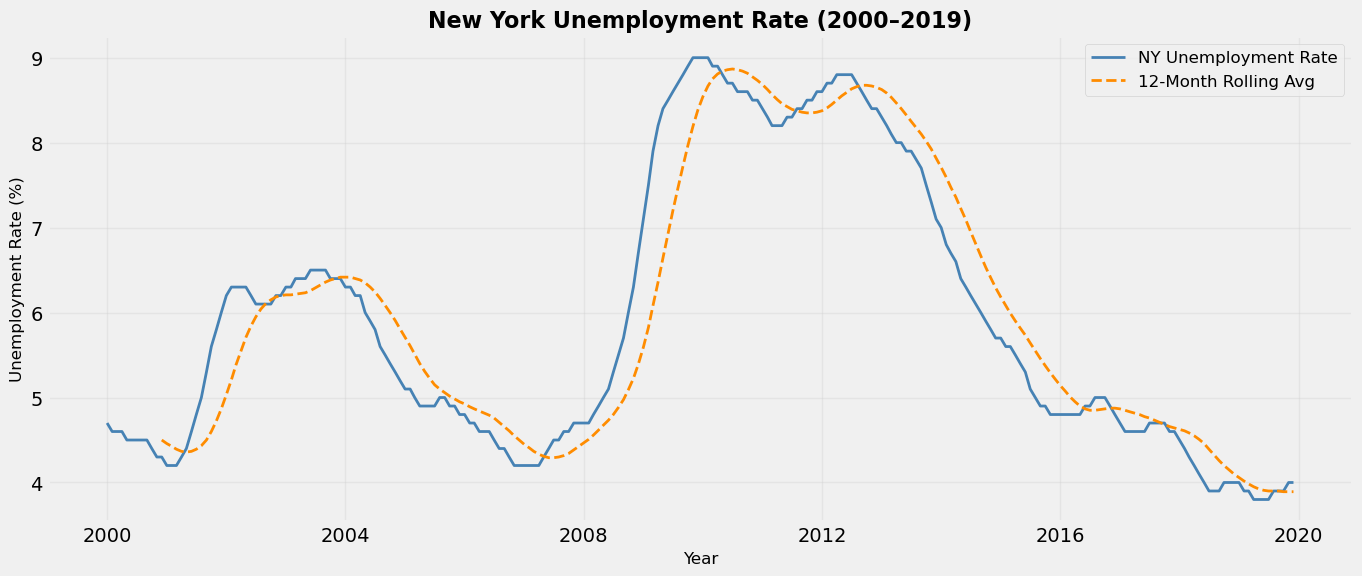

In [15]:
import os
import matplotlib.pyplot as plt

# Output directory
output_dir = r"C:\Users\ANITA BOADU\New York City Bikes\Analysis\Visualizations"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "ny_unemployment_rolling_avg.png")

# Create plot
plt.figure(figsize=(15, 6), dpi=100)

# Original unemployment rate
plt.plot(ts.index, ts['Value'], color='steelblue', linewidth=2, label="NY Unemployment Rate")

# 12-month rolling average
plt.plot(
    ts.index,
    ts['Value'].rolling(window=12).mean(),
    color='darkorange',
    linewidth=2,
    linestyle="--",
    label="12-Month Rolling Avg"
)

# Titles and labels
plt.title("New York Unemployment Rate (2000–2019)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unemployment Rate (%)", fontsize=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## Line Chart with Rolling Average

The chart above shows the **New York Unemployment Rate (2000–2019)**.

The **blue line** shows the actual monthly unemployment rate.
The **orange dashed line** represents a 12-month rolling average, which smooths short-term variations and emphasizes the long-term trend.

Key insights:

- **2008–2009 Financial Crisis**: Unemployment rose sharply, reaching a peak of nearly 9%.

- **Recovery Phase (2010–2019)**: Unemployment gradually declined, falling to about 4% before 2020.

- The rolling average helps highlight the broader economic cycles more clearly than the raw monthly data.

This enhanced line chart provides both detail (monthly changes) and clarity (smoothed trend), making it one of the best ways to visualize unemployment data over time.


## Thoughts on the Line Chart with Rolling Average

The chart presents both detailed and smoothed views of the New York unemployment rate from 2000–2019:

- **Cyclic behavior**: The blue line (monthly data) displays clear cycles, with unemployment rising and falling over multiple years. These patterns reflect typical economic expansions and recessions.

- **2008–2009 Financial Crisis**: Unemployment surged sharply, peaking near 9%. The orange dashed line (rolling average) highlights this upward trend clearly.

- **Recovery phase (2010–2019)**: A gradual and sustained decline in unemployment is evident, falling to about 4% before 2020. The rolling average shows a smooth downward path, filtering out short-term fluctuations.

- **Usefulness of rolling average**: While the raw monthly data exhibits volatility, the rolling average captures the underlying trend more clearly, making it easier to interpret the overall direction of the labor market.

Overall, the line chart confirms that New York’s unemployment rate follows economic cycles rather than moving randomly, with major events like the financial crisis leaving distinct marks on the series. This makes it a solid foundation for further time series analysis, such as decomposition and stationarity testing.

# Decompose the data’s components

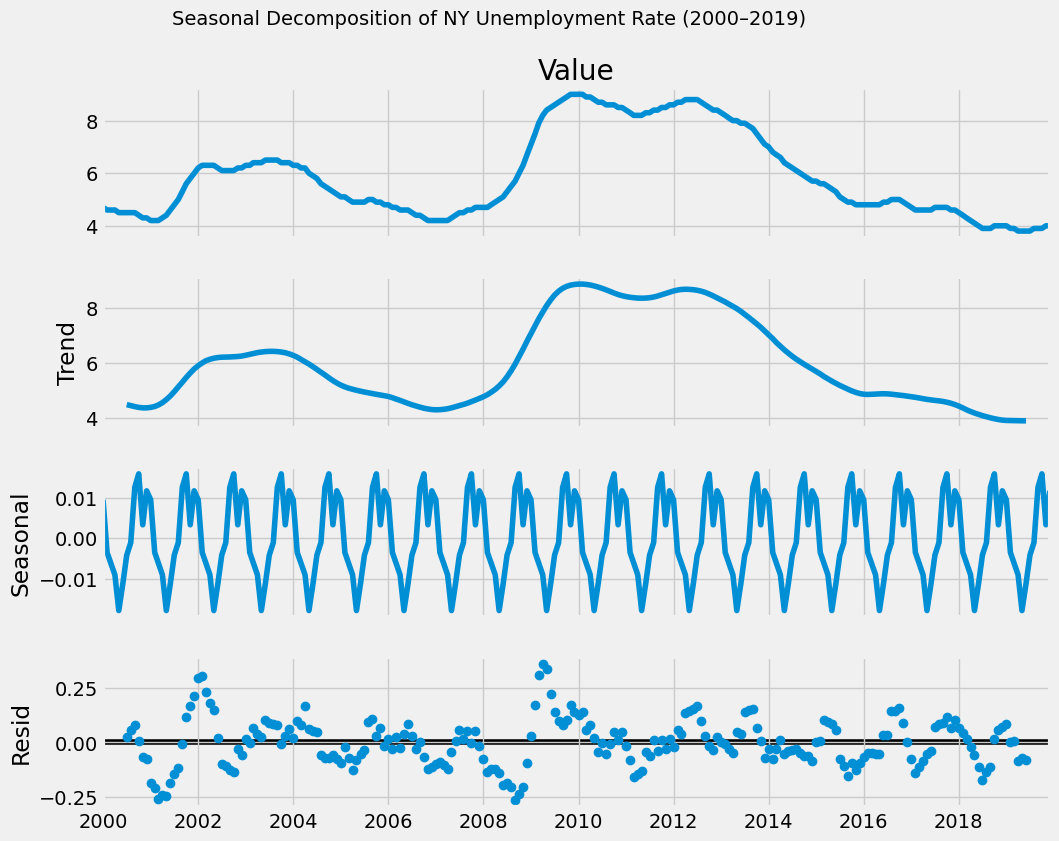

In [16]:
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Output directory
output_dir = r"C:\Users\ANITA BOADU\New York City Bikes\Analysis\Visualizations"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "ny_unemployment_decomposition.png")

# Decompose with monthly frequency (period=12)
decomp = seasonal_decompose(ts['Value'], model='additive', period=12)

# Plot decomposition
fig = decomp.plot()  # returns a matplotlib figure object
fig.set_size_inches(12, 9)
fig.suptitle("Seasonal Decomposition of NY Unemployment Rate (2000–2019)", fontsize=14)

# Save figure
fig.savefig(output_file, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## Charts all together

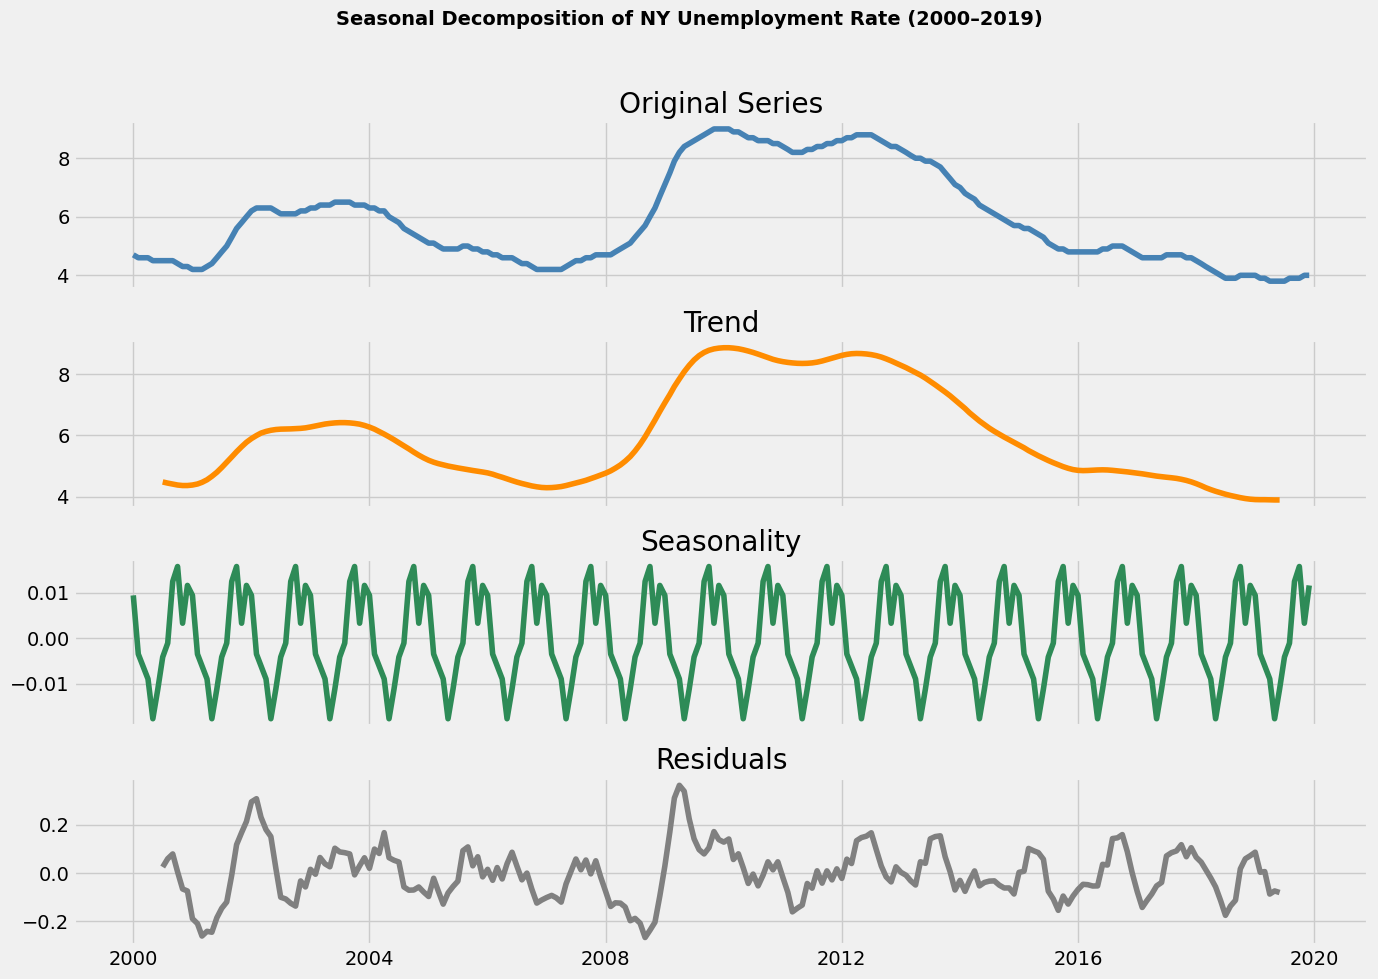

In [17]:
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Output directory
output_dir = r"C:\Users\ANITA BOADU\New York City Bikes\Analysis\Visualizations"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "ny_unemployment_decomposition_custom.png")

# Decompose series
decomp = seasonal_decompose(ts['Value'], model='additive', period=12)

# Create 4-in-1 plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(ts['Value'], color='steelblue')
axes[0].set_title("Original Series")

# Trend
axes[1].plot(decomp.trend, color='darkorange')
axes[1].set_title("Trend")

# Seasonal
axes[2].plot(decomp.seasonal, color='seagreen')
axes[2].set_title("Seasonality")

# Residual
axes[3].plot(decomp.resid, color='gray')
axes[3].set_title("Residuals")

# Overall title
plt.suptitle("Seasonal Decomposition of NY Unemployment Rate (2000–2019)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure
fig.savefig(output_file, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## Comments on the Decomposition Plots

The decomposition breaks down the unemployment rate into four components:

1. **Original Series (Top Panel)**:
The original monthly unemployment data from 2000–2019 exhibits the familiar cyclical pattern. There is a pronounced increase during the 2008–2009 financial crisis, followed by a gradual recovery throughout the 2010s.


2. **Trend (Second Panel)**:
The extracted trend emphasizes long-term upward and downward movements without short-term fluctuations. It clearly shows the sharp rise in unemployment around 2008–2009 and the steady decline leading up to 2019.


3. **Seasonality (Third Panel)**:
The seasonal component reveals a recurring annual pattern, though its magnitude is small compared to the trend. This indicates that unemployment in New York fluctuates slightly within each year, but seasonal effects are minor relative to broader economic shifts.


4. **Residuals (Bottom Panel)**:
The residual component captures irregular variations not explained by trend or seasonality. The residuals are relatively small, suggesting that the decomposition effectively represents the main structure of the data.

**Overall Insight**:
The unemployment rate in New York is primarily driven by **long-term economic cycles** (the trend) with **modest seasonal fluctuations**. The residuals confirm that most variation is explained by the trend, making this series suitable for forecasting once it is made stationary.

# Dickey-Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(ts['Value'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of Lags Used:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:", result[4])

# Quick interpretation inline
if result[1] <= 0.05:
    print("\n✅ Reject Null Hypothesis: Series is Stationary")
else:
    print("\n❌ Fail to Reject Null Hypothesis: Series is Non-Stationary")

ADF Statistic: -2.015151372729004
p-value: 0.2799695180842746
Number of Lags Used: 4
Number of Observations Used: 235
Critical Values: {'1%': np.float64(-3.4584868856997004), '5%': np.float64(-2.873918902362675), '10%': np.float64(-2.573367247623359)}

❌ Fail to Reject Null Hypothesis: Series is Non-Stationary


## Augmented Dickey-Fuller (ADF) Test for Stationarity

**Null Hypothesis (H₀)**: The time series has a unit root → it is **non-stationary**.
**Alternative Hypothesis (H₁)**: The time series is **stationary** (no unit root).

**Test results**:

ADF Statistic = **-2.02**
p-value = **0.28**
Critical values = -3.46 (1%), -2.87 (5%), -2.57 (10%)

**Interpretation**:

The ADF statistic (-2.02) **is not less than** any of the critical values.
The p-value (0.28) is **greater than 0.05**.
Therefore, we **fail to reject the null hypothesis (H₀)**.
This means the unemployment series is **non-stationary** in its current form.
This result is expected: unemployment reflects long-term economic cycles and does not have a constant mean/variance over time.

**Next step**:
We will apply **first differencing** to remove the trend and test again to see if the differenced series becomes stationary.

## Differencing + ADF Test

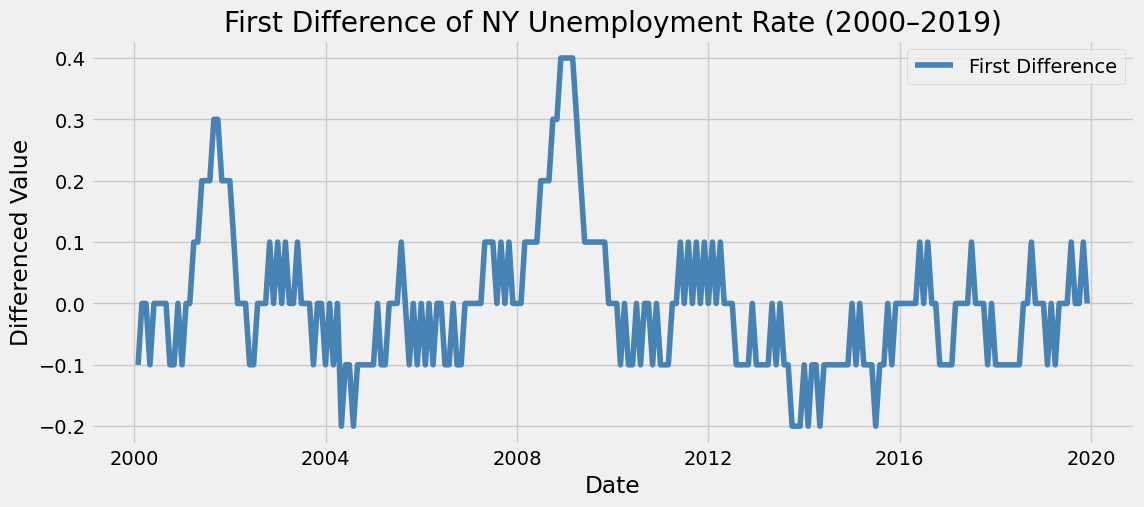

ADF Statistic (Diff): -3.773858764073851
p-value (Diff): 0.0031863882861032293
Number of Lags Used: 3
Number of Observations Used: 235
Critical Values: {'1%': np.float64(-3.4584868856997004), '5%': np.float64(-2.873918902362675), '10%': np.float64(-2.573367247623359)}

✅ Reject Null Hypothesis: Differenced series is Stationary


In [19]:
# First differencing
ts_diff = ts['Value'].diff().dropna()

# Plot differenced series
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(ts_diff, color="steelblue", label="First Difference")
plt.title("First Difference of NY Unemployment Rate (2000–2019)")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.legend()
plt.show()

# ADF Test on differenced series
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(ts_diff)

print("ADF Statistic (Diff):", result_diff[0])
print("p-value (Diff):", result_diff[1])
print("Number of Lags Used:", result_diff[2])
print("Number of Observations Used:", result_diff[3])
print("Critical Values:", result_diff[4])

if result_diff[1] <= 0.05:
    print("\n✅ Reject Null Hypothesis: Differenced series is Stationary")
else:
    print("\n❌ Fail to Reject Null Hypothesis: Differenced series is still Non-Stationary")

## Stationarity Test After Differencing

Since the original unemployment rate series was **non-stationary**, we applied a **first difference** to remove the trend component.

**Null Hypothesis (H₀)**: The time series has a unit root → it is non-stationary.
**Alternative Hypothesis (H₁)**: The time series is stationary.

**Results after first differencing**:

ADF Statistic = **-3.77**
p-value = **0.003**
Critical values = -3.46 (1%), -2.87 (5%), -2.57 (10%)

**Interpretation**:

The ADF statistic (-3.77) is **less than all three critical values**.
The p-value (0.003) is **well below 0.05**.
Therefore, **we reject the null hypothesis** and conclude that the differenced unemployment series is **stationary**.

**Conclusion**:
After first differencing, the series now has stable mean and variance, making it suitable for time series modeling (e.g., ARIMA).

# Check Data’s Autocorrelations

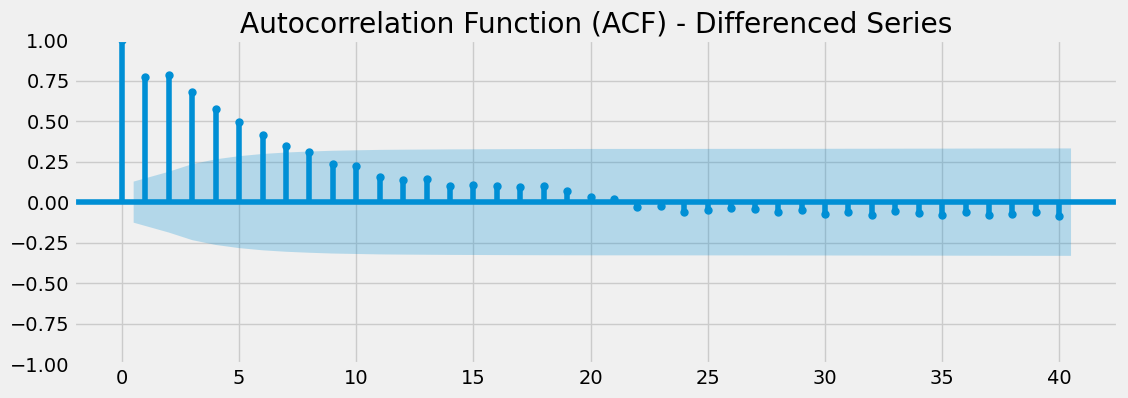

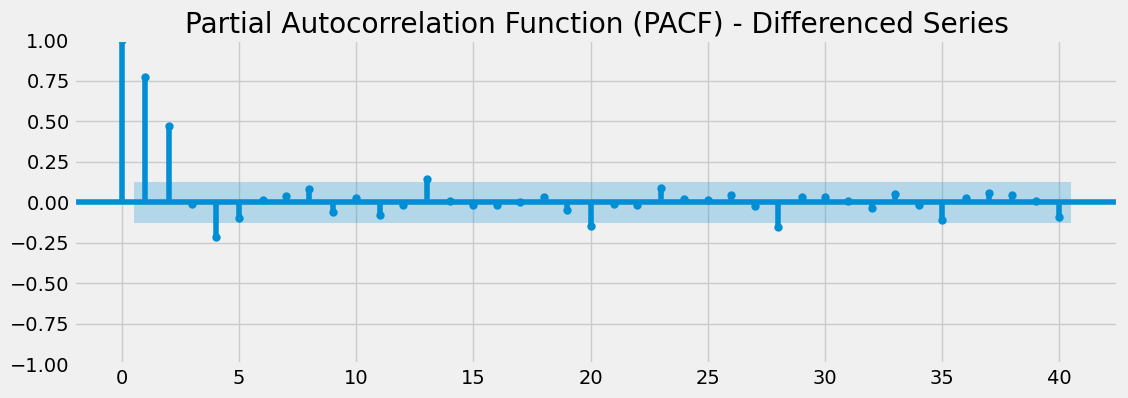

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use the stationary differenced series
series = ts_diff  

plt.figure(figsize=(12,4))
plot_acf(series, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF) - Differenced Series")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series, lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF) - Differenced Series")
plt.show()

## Autocorrelation Analysis (ACF & PACF)

The ACF and PACF plots for the differenced unemployment series reveal:

   1. **ACF (Autocorrelation Function)**:
Strong autocorrelations up to about lag 10 that gradually decay toward zero.
This is consistent with an autoregressive (AR) structure.

2. **PACF (Partial Autocorrelation Function)**:
Large, significant spikes at lags 1 and 2, with smaller contributions at lag 3, after which the correlations drop into the confidence interval.

This cutoff pattern suggests an **AR process of order 2–3**.

**Conclusion**:
The unemployment series, after first differencing, appears to follow an **ARIMA(p,1,0)** structure, where **p ≈ 2 or 3**.
This means the series can likely be modeled with **ARIMA(2,1,0)** or **ARIMA(3,1,0)**.
Further testing (AIC/BIC comparisons) can confirm the best-fitting parameters.